In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from operator import itemgetter
import os
from tqdm import tqdm

from umap import UMAP
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp, wilcoxon

In [11]:
wilcoxon(lvcs['n'], lvcs_synt['n'])

WilcoxonResult(statistic=np.float64(8242.5), pvalue=np.float64(0.0006473472146518345))

We load data produced in the **1_data_production** notebook, specifically:
- Largest Viable Component size
- page-rank node percolation critical point 
- number of modules and modularity from DCSBM

In [2]:
working_dir = "data_old/"

# storage dictionaries, one for each data type
lvcs, crit_points, mods, mody = {} , {}, {}, {}
max_len = 258
file_names = np.sort(os.listdir(working_dir+"LVC/original/"))
names = np.array([f[:-4] for f in file_names])
for file in file_names:
    lvcs[file[:-4]] = np.loadtxt(working_dir+"LVC/original/"+file, dtype=int)[:max_len]
    crit_points[file[:-4]] = np.loadtxt(working_dir+"percolation/original/"+file, dtype=float)[:max_len]
    mods[file[:-4]] = np.loadtxt(working_dir+"modules/original/"+file, dtype=int)[:max_len]
    mody[file[:-4]] = np.loadtxt(working_dir+"modularity/original/"+file, dtype=float)[:max_len]

# get sizes of the combination sets
sizes = {f:len(lvcs[f]) for f in lvcs}

In [3]:
human_nodes = pd.read_csv("data/BIOSTR_homo_sapiens.nodes", sep=" ")
human_map = dict(zip(human_nodes['nodeSymbol'], np.arange(len(human_nodes))))

virus_names = np.sort(os.listdir("data/SyntheticViruses/original"))
virus_metadata = pd.read_csv("data/viruses_metadata.csv", header=0, sep=";")
virus_onco = virus_metadata[virus_metadata["isOncogenic"] == True].virus.unique()
virus_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].virus.unique()

synt_files = np.sort(os.listdir("data/SyntheticViruses/"))[:5]

virus_dict = {i : vname for i, vname in enumerate(virus_names)}

virus_onco_idx = np.where(np.isin(virus_names, virus_onco))[0]
virus_nonco_idx = np.where(np.isin(virus_names, virus_nonco))[0]

# Figure 2, topological quantities distribution

Boxplot of the distribution of the quantities divided into the combination sets used as Fig.3 in the article

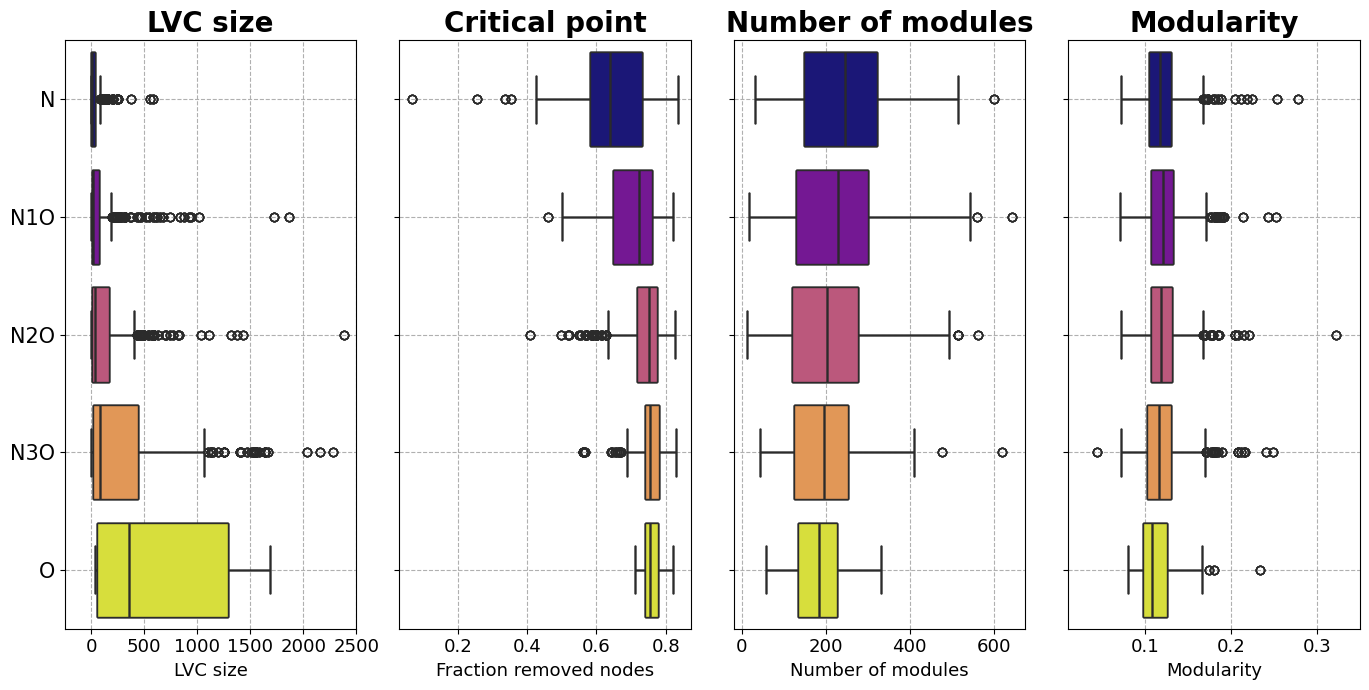

In [63]:
### Boxplots of the quantities (Fig.3) ###
##########################################

plt.figure(figsize=(14,7))

# LVC size
plt.subplot(1,4,1)
data = [lvcs[key] for key in lvcs.keys()]
names = list(lvcs.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("LVC size", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels=[n.upper() for n in names], fontsize=15)
plt.xticks(fontsize=13)
plt.xlabel("LVC size", fontsize=13)
plt.ylabel("")
plt.xlim(-250, 2500)
plt.grid(ls="--")
plt.tight_layout()

# Critical point
plt.subplot(1,4,2)
data = [1-crit_points[key] for key in crit_points.keys()]
names = list(crit_points.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("Critical point", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels="")
plt.xticks(fontsize=13)
plt.xlabel("Fraction removed nodes", fontsize=13)
plt.ylabel("")
plt.grid(ls="--")
plt.tight_layout()

# Number of modules
plt.subplot(1,4,3)
data = [mods[key] for key in mods.keys()]
names = list(mods.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("Number of modules", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels="")
plt.xticks(fontsize=13)
plt.xlabel("Number of modules", fontsize=13)
plt.ylabel("")
plt.grid(ls="--")
plt.tight_layout()

# Modularity
plt.subplot(1,4,4)
data = [mody[key] for key in mody.keys()]
names = list(mody.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("Modularity", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels="")
plt.xticks(fontsize=13)
plt.xlabel("Modularity", fontsize=13)
plt.ylabel("")
plt.xlim(0.01, 0.35)
plt.grid(ls="--")
plt.tight_layout()

# Figure 3, combined features classification

This section focuses on combining topological parameters to **distinguish between different combination sets**. By applying the **UMAP** algorithm for dimensionality reduction, we aim to project the selected features into a lower-dimensional space, facilitating the identification of "oncogenic" and "non-oncogenic" regions within the data.

For the classification we use a SVM to distinguish regions of the parameter space associated to the *O* and *N* combination set.

In [6]:
# organize all the data in a single object of dimension (n_features, n_combination_sets)
data = [[d[key] for key in d.keys()] for d in [lvcs, crit_points, mods, mody]]

# rearrange in to have vectors of dimension (n_combination_sets, n_features)
data_all = []
for i in range(len(data[0])):
    data_all.append([])
    for j in range(len(data)):
        data_all[i].append(data[j][i])
    data_all[i] = np.array(data_all[i])
data_all = np.concatenate(data_all, axis=1) # final shape (n_combination_sets, n_features)

/home/francesco/anaconda3/envs/bioenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


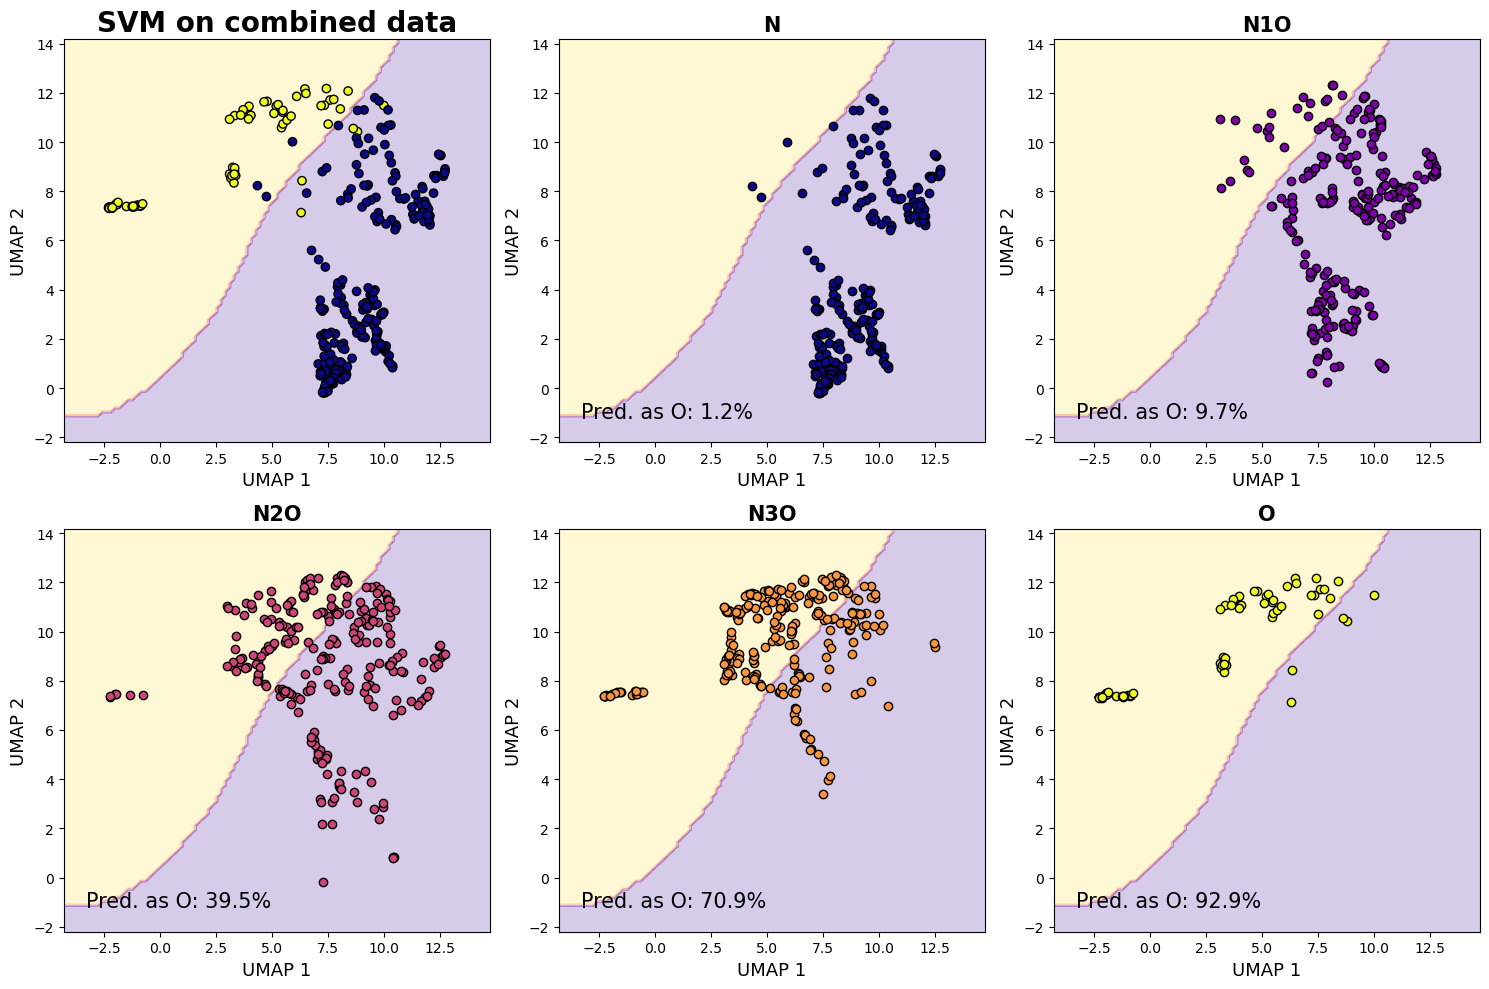

In [10]:
# Apply UMAP for dimensionality reduction
np.random.seed(1234)
reducer = UMAP(random_state=1234)
scaler = StandardScaler() # scale data before UMAP
data_scaled = scaler.fit_transform(data_all.T)
embedding = reducer.fit_transform(data_scaled)

# Prepare data for SVM classification, considering only O and N combination sets
X = np.concatenate([embedding[-sizes['o']:,:], embedding[:sizes['n'],:]], axis=0)
y = np.concatenate([[0]*sizes['o'],[1]*sizes['n']]) # 0 for O, 1 for N

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Define plot limits
xlims = (X[:,0].min()-2, X[:,0].max()+2)
ylims = (X[:,1].min()-2, X[:,1].max()+2)

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(xlims[0], xlims[1], 100),
                     np.linspace(ylims[0], ylims[1], 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

# Plotting

# Define colors for each combination set
colors = {file_names[i][:-4]: sns.color_palette("plasma", as_cmap=True)(np.linspace(0, 1, len(file_names)))[i] for i in range(len(file_names))}
c = itemgetter(*np.concatenate([['o']*sizes["o"]+['n']*sizes["n"]]))(colors)

_ , ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

# Plot combined data with decision boundary
ax[0].scatter(X[:,0], X[:,1], c=c, edgecolors='k', zorder=2)
ax[0].contourf(xx, yy, Z, cmap=plt.cm.plasma_r, alpha=0.2)

# Plot each combination set separately with decision boundary and classification result
for i in range(len(file_names)):
    lim0 = np.sum([sizes[names[j]] for j in range(i)]).astype(int)
    lim1 = int(lim0 + sizes[names[i]])
    ax[i+1].scatter(embedding[lim0:lim1,0], embedding[lim0:lim1,1], 
                    color=colors[file_names[i][:-4]], edgecolors='k', zorder=2)
    ax[i+1].contourf(xx, yy, Z, cmap=cm.plasma_r, alpha=0.2)
    class_res = 1-classifier.score(embedding[lim0:lim1,:], np.concatenate([[1]*sizes[names[i]]]))
    ax[i+1].text(xlims[0]+1, ylims[0]+1, f'Pred. as O: {class_res*100:.1f}%', fontsize=15)
[axi.set_xlabel('UMAP 1', fontsize=13) for axi in ax]
[axi.set_ylabel('UMAP 2', fontsize=13) for axi in ax]
ax[0].set_title('SVM on combined data', fontsize=20, fontweight="bold")
[ax[i+1].set_title(f'{file_names[i][:-4].upper()}', fontsize=15, fontweight="bold") for i in range(len(file_names))]
[axi.set_xlim(xlims) for axi in ax]
[axi.set_ylim(ylims) for axi in ax]
plt.tight_layout()
plt.show()

# Supplementary material

## LVC synt distr

In [99]:
working_dir = "data/"

In [ ]:
# Get list of type 1 nodes for each virus
virus_nodes1_list, virus_nodes1_dict = [], {}
target_folder = "data/Virus_data_Enriched_0.7_Neigh_0/"

neigh_ord_1_indexes = virus_metadata[virus_metadata["neigh_order"]==1].index.values

for i, vi in enumerate(neigh_ord_1_indexes):
    read_nodes = pd.read_csv(target_folder+"/"+virus_metadata.loc[vi,"virus"]+"/nodes.csv")
    virus_nodes1 = list(read_nodes[read_nodes["type"]==1].node)    
    virus_nodes1_list.append(virus_nodes1)
    virus_nodes1_dict[virus_metadata.loc[vi,"virus_short"]] = virus_nodes1

In [101]:
num_edges_synt = []
num_edges_or = []
t1_perc_synt = []
t1_perc_or = []
for i,v in tqdm(enumerate(virus_names)):
    e0 = np.loadtxt(working_dir+f"SyntheticViruses/{0}/"+v+"/edges.csv", dtype=str, skiprows=1)
    e0 = np.array([e.split(",") for e in e0])
    num_edges_synt.append(len(e0))
    t1_perc_synt.append(np.sum(np.any(np.isin(e0, virus_nodes1_list[i]), axis=1)))

    eor = np.loadtxt(working_dir+f"SyntheticViruses/original/"+v+"/edges.csv", dtype=str, skiprows=1)
    eor = np.array([e.split(",") for e in eor])
    num_edges_or.append(len(eor))
    t1_perc_or.append(np.sum(np.any(np.isin(eor, virus_nodes1_list[i]), axis=1)))

t1_perc_synt = np.array(t1_perc_synt)
t1_perc_or = np.array(t1_perc_or)
t1_len = np.array([len(g) for g in virus_nodes1_list])

79it [00:37,  2.08it/s]


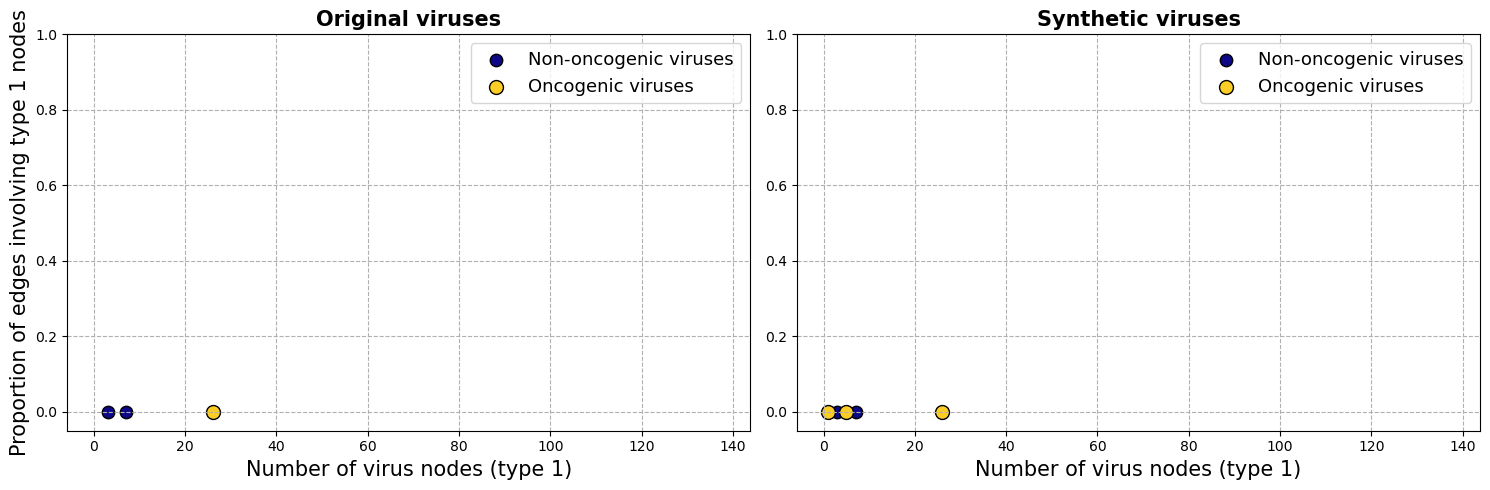

In [102]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(t1_len, t1_perc_or, facecolors=sns.color_palette("plasma", as_cmap=True)(0), edgecolors='k', s=80, label='Non-oncogenic viruses')
plt.scatter(t1_len[virus_onco_idx], t1_perc_or[virus_onco_idx], edgecolors='k', s=100, facecolors=sns.color_palette("plasma", as_cmap=True)(0.9), label='Oncogenic viruses')
plt.grid(ls="--")
plt.legend(fontsize=13)
plt.xlabel("Number of virus nodes (type 1)", fontsize=15)
plt.ylabel("Proportion of edges involving type 1 nodes", fontsize=15)
plt.title("Original viruses", fontweight="bold", fontsize=15)
plt.ylim(-0.05,1)
plt.subplot(1,2,2)
plt.scatter(t1_len, t1_perc_synt, facecolors=sns.color_palette("plasma", as_cmap=True)(0), edgecolors='k', s=80, label='Non-oncogenic viruses')
plt.scatter(t1_len[virus_onco_idx], t1_perc_synt[virus_onco_idx], edgecolors='k', s=100, facecolors=sns.color_palette("plasma", as_cmap=True)(0.9), label='Oncogenic viruses')
plt.grid(ls="--")
plt.legend(fontsize=13)
plt.xlabel("Number of virus nodes (type 1)", fontsize=15)
plt.title("Synthetic viruses", fontweight="bold", fontsize=15)
plt.ylim(-0.05,1)
plt.tight_layout()

## Distribution comparisons

In [4]:
working_dir = "data_old/"

# storage dictionaries, one for each data type
lvcs_synt, crit_points_synt, mods_synt, mody_synt = {} , {}, {}, {}
max_len = 258
file_names = np.sort(os.listdir(working_dir+"LVC/0/"))
names = np.array([f[:-4] for f in file_names])
for file in file_names:
    lvcs_synt[file[:-4]] = np.loadtxt(working_dir+"LVC/0/"+file, dtype=int)[:max_len]
    crit_points_synt[file[:-4]] = np.loadtxt(working_dir+"percolation/0/"+file, dtype=float)[:max_len]
    mods_synt[file[:-4]] = np.loadtxt(working_dir+"modules/0/"+file, dtype=int)[:max_len]
    mody_synt[file[:-4]] = np.loadtxt(working_dir+"modularity/0/"+file, dtype=float)[:max_len]

# get sizes of the combination sets
sizes = {f:len(lvcs_synt[f]) for f in lvcs_synt}

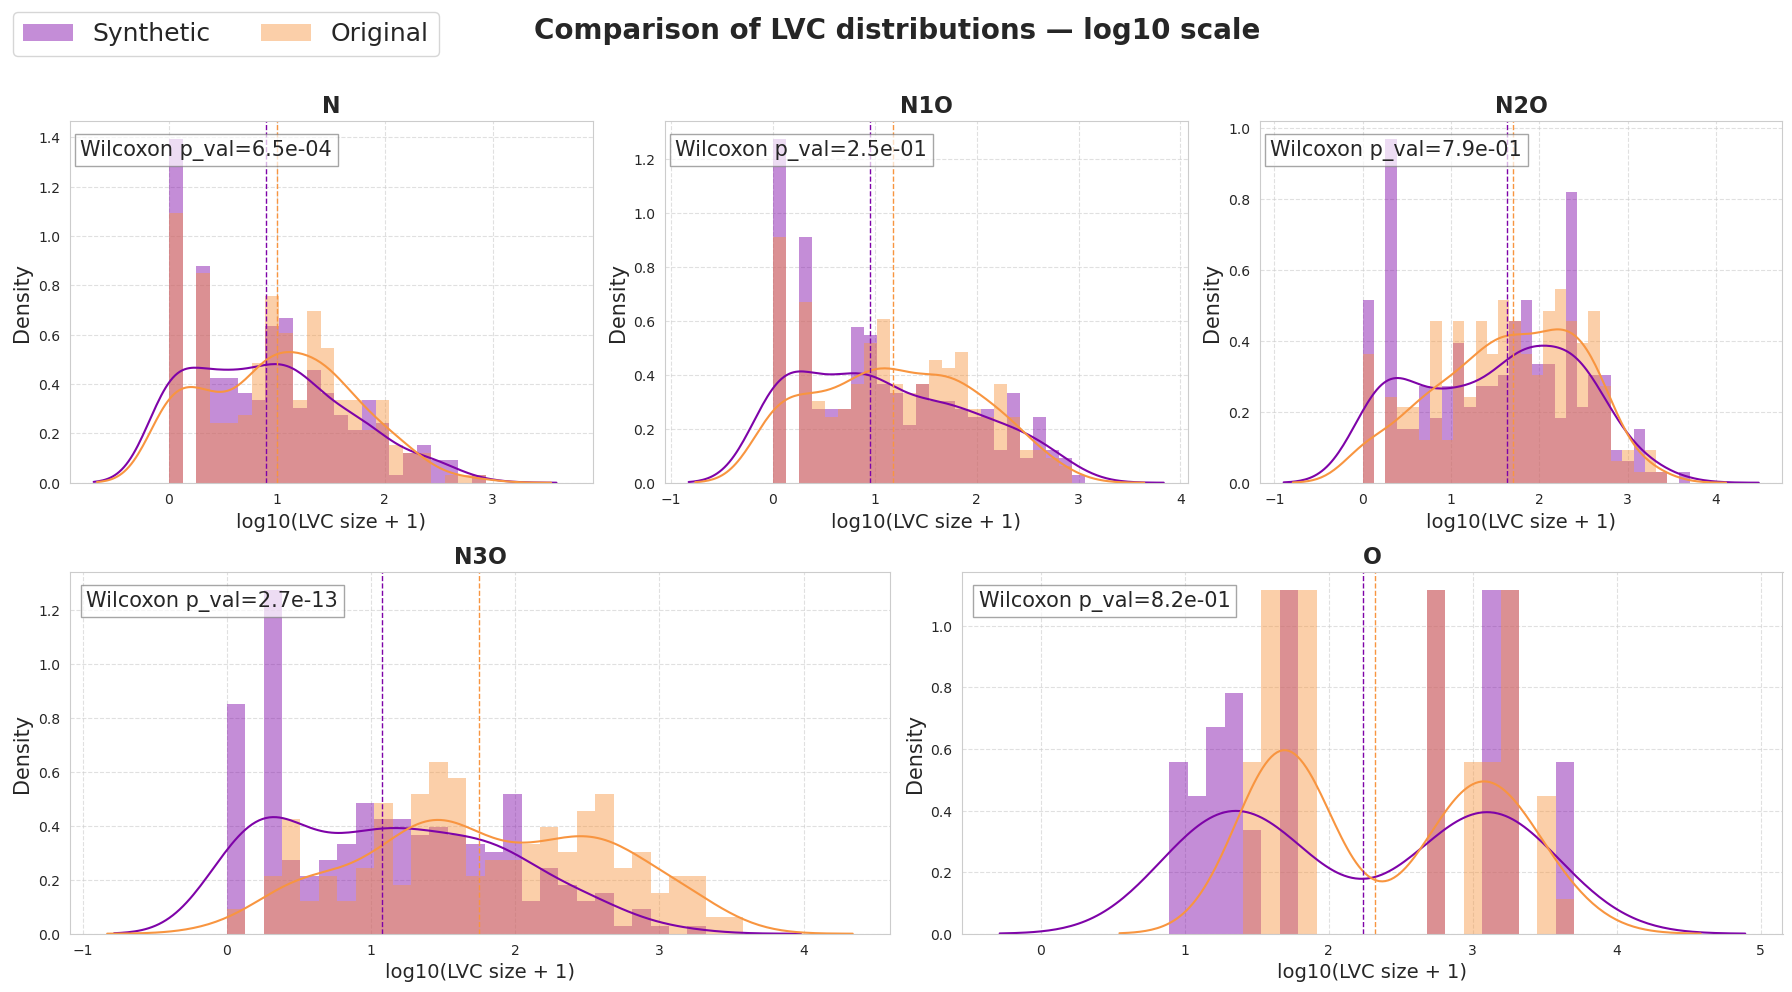

In [ ]:
sns.set_style("whitegrid")

from matplotlib.gridspec import GridSpec

# Figure and layout
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 6, figure=fig)  # 2 rows, 6 columns

# Subplots layout (3 on first row, 2 large on second)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])
axes = [ax1, ax2, ax3, ax4, ax5]

# Use only as many file_names as axes
fnames = list(file_names[:len(axes)])
keys = [f[:-4] for f in fnames]

# Prepare global bins on log10 scale to make comparisons easier
all_vals = []
for k in keys:
    all_vals.append(np.log10(np.array(lvcs_synt[k], dtype=float) + 1))
    all_vals.append(np.log10(np.array(lvcs[k], dtype=float) + 1))
all_vals = np.concatenate(all_vals)
bins = np.linspace(all_vals.min(), all_vals.max(), 30)

# Colors
syn_col = sns.color_palette("plasma", 3)[0]
orig_col = sns.color_palette("plasma", 3)[2]

for k, axi in zip(keys, axes):
    synt = np.array(lvcs_synt[k], dtype=float)
    orig = np.array(lvcs[k], dtype=float)

    synt_log = np.log10(synt + 1)
    orig_log = np.log10(orig + 1)

    # Histogram (filled, semi-transparent) and KDE
    axi.hist(synt_log, bins=bins, density=True, alpha=0.45, color=syn_col,
             label=f'Synthetic', edgecolor='none')
    axi.hist(orig_log, bins=bins, density=True, alpha=0.45, color=orig_col,
             label=f'Original', edgecolor='none')
    sns.kdeplot(synt_log, ax=axi, color=syn_col, lw=1.5)
    sns.kdeplot(orig_log, ax=axi, color=orig_col, lw=1.5)

    # Median lines (on log scale)
    m_syn = np.median(synt_log)
    m_orig = np.median(orig_log)
    axi.axvline(m_syn, color=syn_col, ls='--', lw=1)
    axi.axvline(m_orig, color=orig_col, ls='--', lw=1)

    # KS test
    ksres = wilcoxon(synt, orig)
    pval = ksres.pvalue
    stat = ksres.statistic
    axi.text(0.02, 0.95,
             f'Wilcoxon p_val={pval:.1e}',
             transform=axi.transAxes,
             verticalalignment='top', fontsize=15,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    # Titles and labels
    axi.set_title(k.upper(), fontsize=16, fontweight='bold')
    axi.set_xlabel('log10(LVC size + 1)', fontsize=14)
    axi.set_ylabel('Density', fontsize=15)
    axi.grid(ls='--', alpha=0.6)


# Single shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=18, frameon=True)

fig.suptitle('Comparison of LVC distributions — log10 scale', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


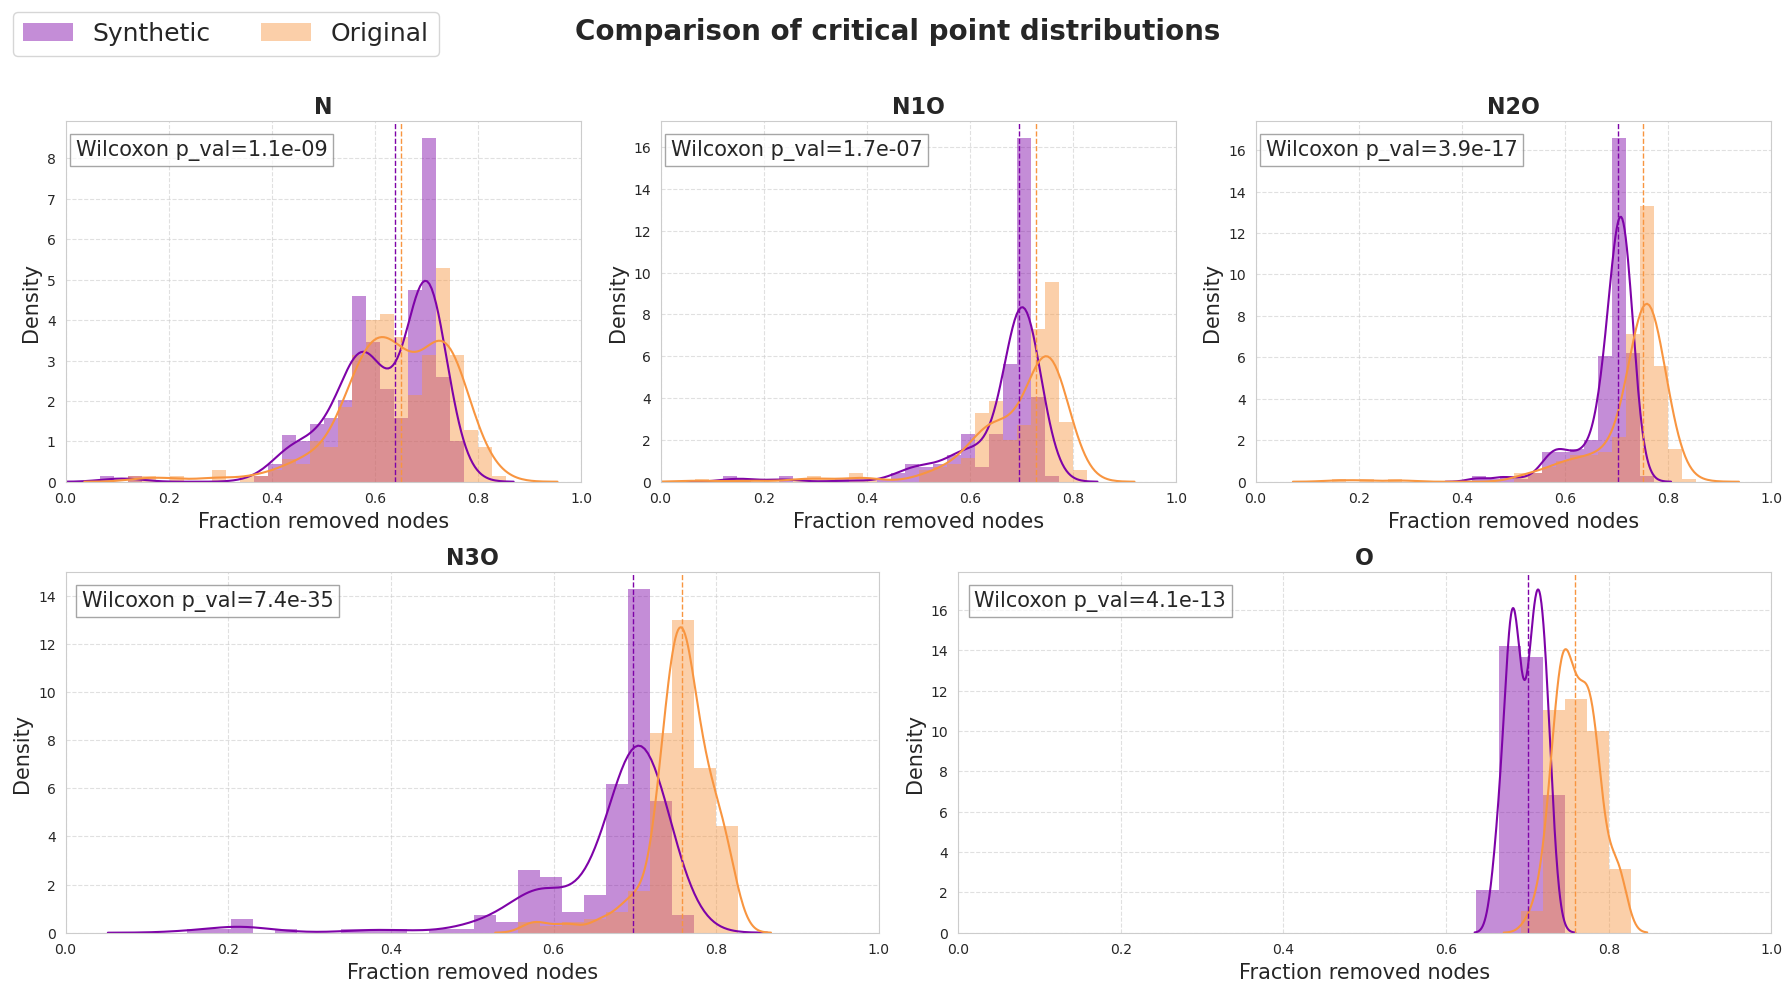

In [40]:
# Compare critical points (fraction removed nodes = 1 - crit_point) between synthetic and original
sns.set_style("whitegrid")

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 6, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])
axes = [ax1, ax2, ax3, ax4, ax5]

fnames = list(file_names[:len(axes)])
keys = [f[:-4] for f in fnames]

# prepare global bins for easy comparison (critical points are fractions ~[0,1])
all_vals = []
for k in keys:
    synt_vals = 1 - np.array(crit_points_synt[k], dtype=float)
    orig_vals  = 1 - np.array(crit_points[k], dtype=float)
    all_vals.append(synt_vals)
    all_vals.append(orig_vals)
all_vals = np.concatenate(all_vals)
bins = np.linspace(max(0, all_vals.min()), min(1, all_vals.max()), 30)

syn_col = sns.color_palette("plasma", 3)[0]
orig_col = sns.color_palette("plasma", 3)[2]

for k, axi in zip(keys, axes):
    synt_vals = 1 - np.array(crit_points_synt[k], dtype=float)
    orig_vals  = 1 - np.array(crit_points[k], dtype=float)

    axi.hist(synt_vals, bins=bins, density=True, alpha=0.45, color=syn_col, label='Synthetic', edgecolor='none')
    axi.hist(orig_vals,  bins=bins, density=True, alpha=0.45, color=orig_col, label='Original', edgecolor='none')
    sns.kdeplot(synt_vals, ax=axi, color=syn_col, lw=1.5)
    sns.kdeplot(orig_vals,  ax=axi, color=orig_col, lw=1.5)

    m_syn = np.median(synt_vals)
    m_orig = np.median(orig_vals)
    axi.axvline(m_syn, color=syn_col, ls='--', lw=1)
    axi.axvline(m_orig, color=orig_col, ls='--', lw=1)

    ksres = wilcoxon(synt_vals[:min(len(synt_vals), len(orig_vals))], orig_vals[:min(len(synt_vals), len(orig_vals))])
    pval = ksres.pvalue
    stat = ksres.statistic
    axi.text(0.02, 0.95, f'Wilcoxon p_val={pval:.1e}', transform=axi.transAxes,
             verticalalignment='top', fontsize=15, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    axi.set_title(k.upper(), fontsize=16, fontweight='bold')
    axi.set_xlabel('Fraction removed nodes', fontsize=15)
    axi.set_ylabel('Density', fontsize=15)
    axi.set_xlim(0, 1)
    axi.grid(ls='--', alpha=0.6)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=18, frameon=True)

fig.suptitle('Comparison of critical point distributions', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


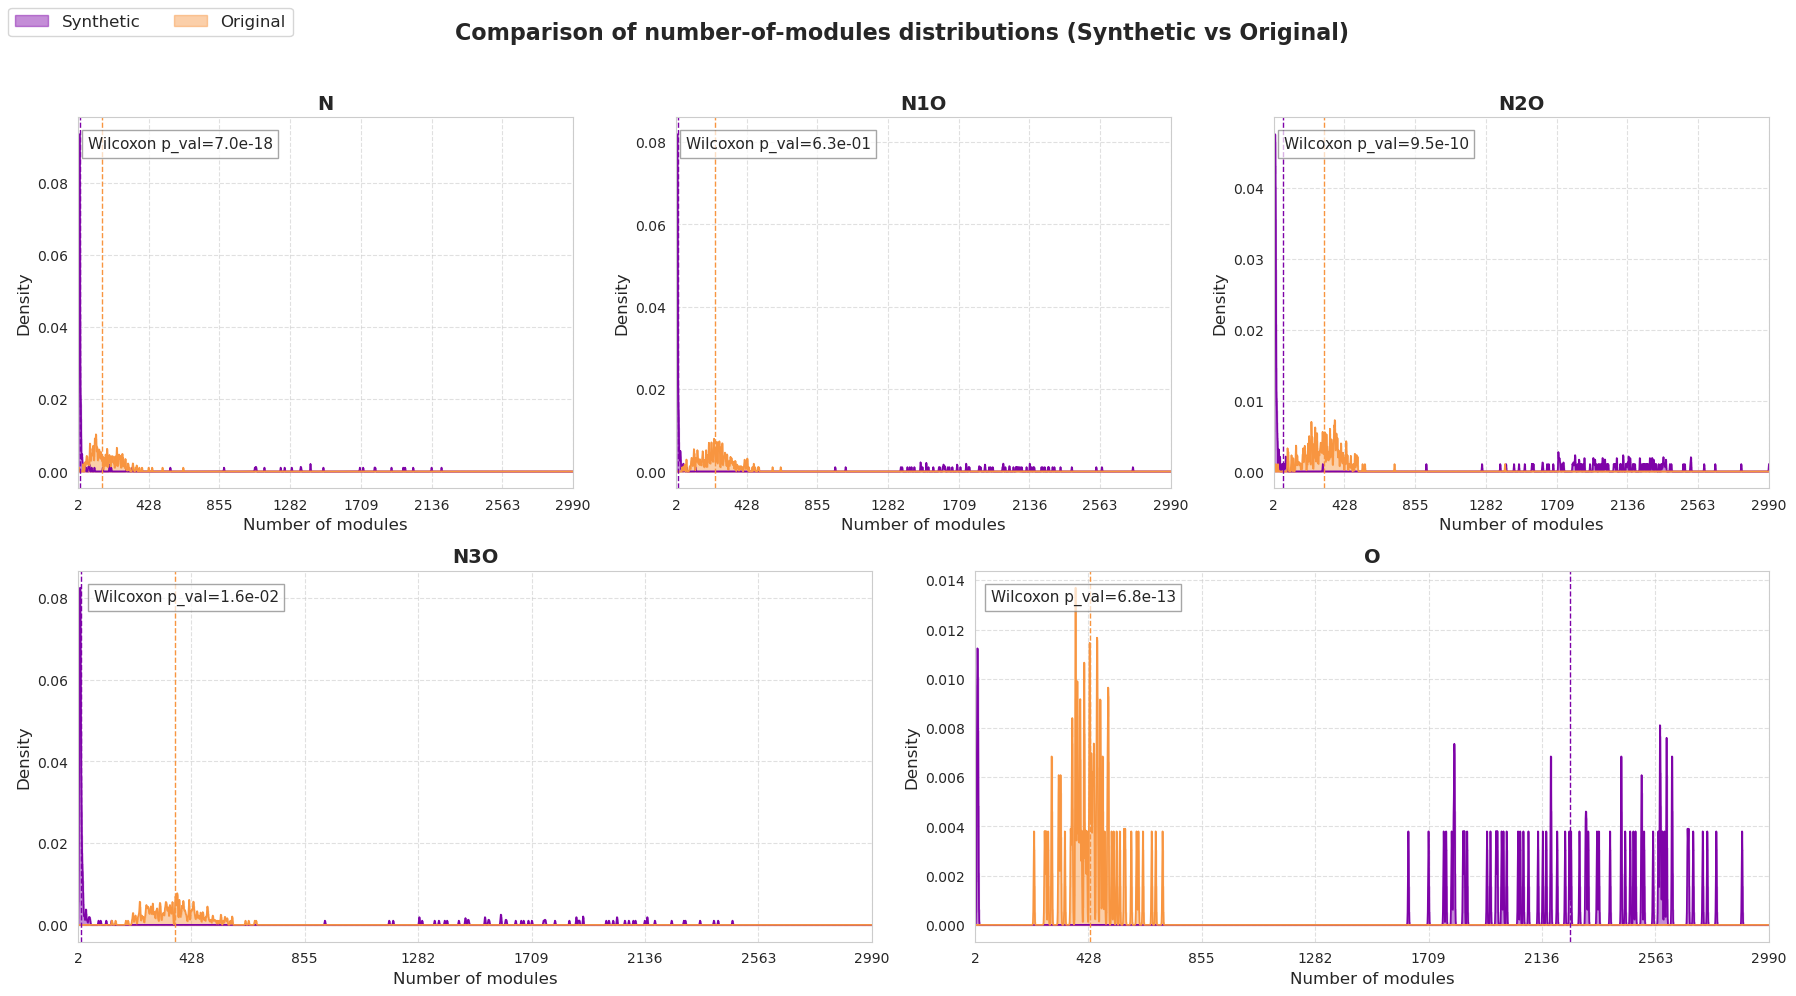

In [24]:
# Compare number of modules between synthetic and original (optimized)
sns.set_style("whitegrid")

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 6, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])
axes = [ax1, ax2, ax3, ax4, ax5]

fnames = list(file_names[:len(axes)])
keys = [f[:-4] for f in fnames]

# gather global integer range for bins
all_vals = np.concatenate([np.array(mods_synt[k], dtype=float) for k in keys] +
                          [np.array(mods[k], dtype=float) for k in keys])
min_int = int(max(0, np.floor(all_vals.min())))
max_int = int(np.ceil(all_vals.max()))
bins = np.arange(min_int - 0.5, max_int + 1.5, 1.0)
bin_centers = (bins[:-1] + bins[1:]) / 2.0

syn_col = sns.color_palette("plasma", 3)[0]
orig_col = sns.color_palette("plasma", 3)[2]

# prepare a small Gaussian kernel for fast smoothing (convolution is much faster than repeated KDE)
kernel_sigma = 1.5
kernel_radius = int(4 * kernel_sigma)
xk = np.arange(-kernel_radius, kernel_radius + 1)
kernel = np.exp(-0.5 * (xk / kernel_sigma) ** 2)
kernel = kernel / kernel.sum()

for k, axi in zip(keys, axes):
    synt_vals = np.array(mods_synt[k], dtype=float)
    orig_vals  = np.array(mods[k], dtype=float)

    # Fast histogram-based density estimate (shared bins)
    synt_counts, _ = np.histogram(synt_vals, bins=bins)
    orig_counts, _  = np.histogram(orig_vals, bins=bins)

    # normalize to get density (area sums to 1)
    if synt_counts.sum() > 0:
        synt_density = synt_counts / (synt_counts.sum())
    else:
        synt_density = synt_counts.astype(float)
    if orig_counts.sum() > 0:
        orig_density = orig_counts / (orig_counts.sum())
    else:
        orig_density = orig_counts.astype(float)

    # Smooth densities with convolution (fast)
    synt_smooth = np.convolve(synt_density, kernel, mode='same')
    orig_smooth  = np.convolve(orig_density, kernel, mode='same')

    # Plot filled histograms (use step-filled for speed) and smoothed lines
    axi.fill_between(bin_centers, synt_smooth, step='mid', alpha=0.45, color=syn_col, label='Synthetic')
    axi.fill_between(bin_centers, orig_smooth, step='mid', alpha=0.45, color=orig_col, label='Original')
    axi.plot(bin_centers, synt_smooth, color=syn_col, lw=1.2)
    axi.plot(bin_centers, orig_smooth, color=orig_col, lw=1.2)

    # Median lines
    m_syn = np.median(synt_vals)
    m_orig = np.median(orig_vals)
    axi.axvline(m_syn, color=syn_col, ls='--', lw=1)
    axi.axvline(m_orig, color=orig_col, ls='--', lw=1)

    # KS test (on raw integer arrays)
    ksres = wilcoxon(synt_vals[:min(len(synt_vals), len(orig_vals))], orig_vals[:min(len(synt_vals), len(orig_vals))])
    pval = ksres.pvalue
    stat = ksres.statistic
    axi.text(0.02, 0.95, f'Wilcoxon p_val={pval:.1e}', transform=axi.transAxes,
             verticalalignment='top', fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    axi.set_title(k.upper(), fontsize=14, fontweight='bold')
    axi.set_xlabel('Number of modules', fontsize=12)
    axi.set_ylabel('Density', fontsize=12)

    # Limit xticks to at most 8 ticks to keep plotting fast & readable
    n_ticks = min(8, max_int - min_int + 1)
    if n_ticks > 1:
        xticks = np.linspace(min_int, max_int, n_ticks, dtype=int)
    else:
        xticks = np.array([min_int])
    axi.set_xticks(xticks)

    axi.set_xlim(min_int - 0.5, max_int + 0.5)
    axi.grid(ls='--', alpha=0.6)

# Single shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=12, frameon=True)

fig.suptitle('Comparison of number-of-modules distributions (Synthetic vs Original)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


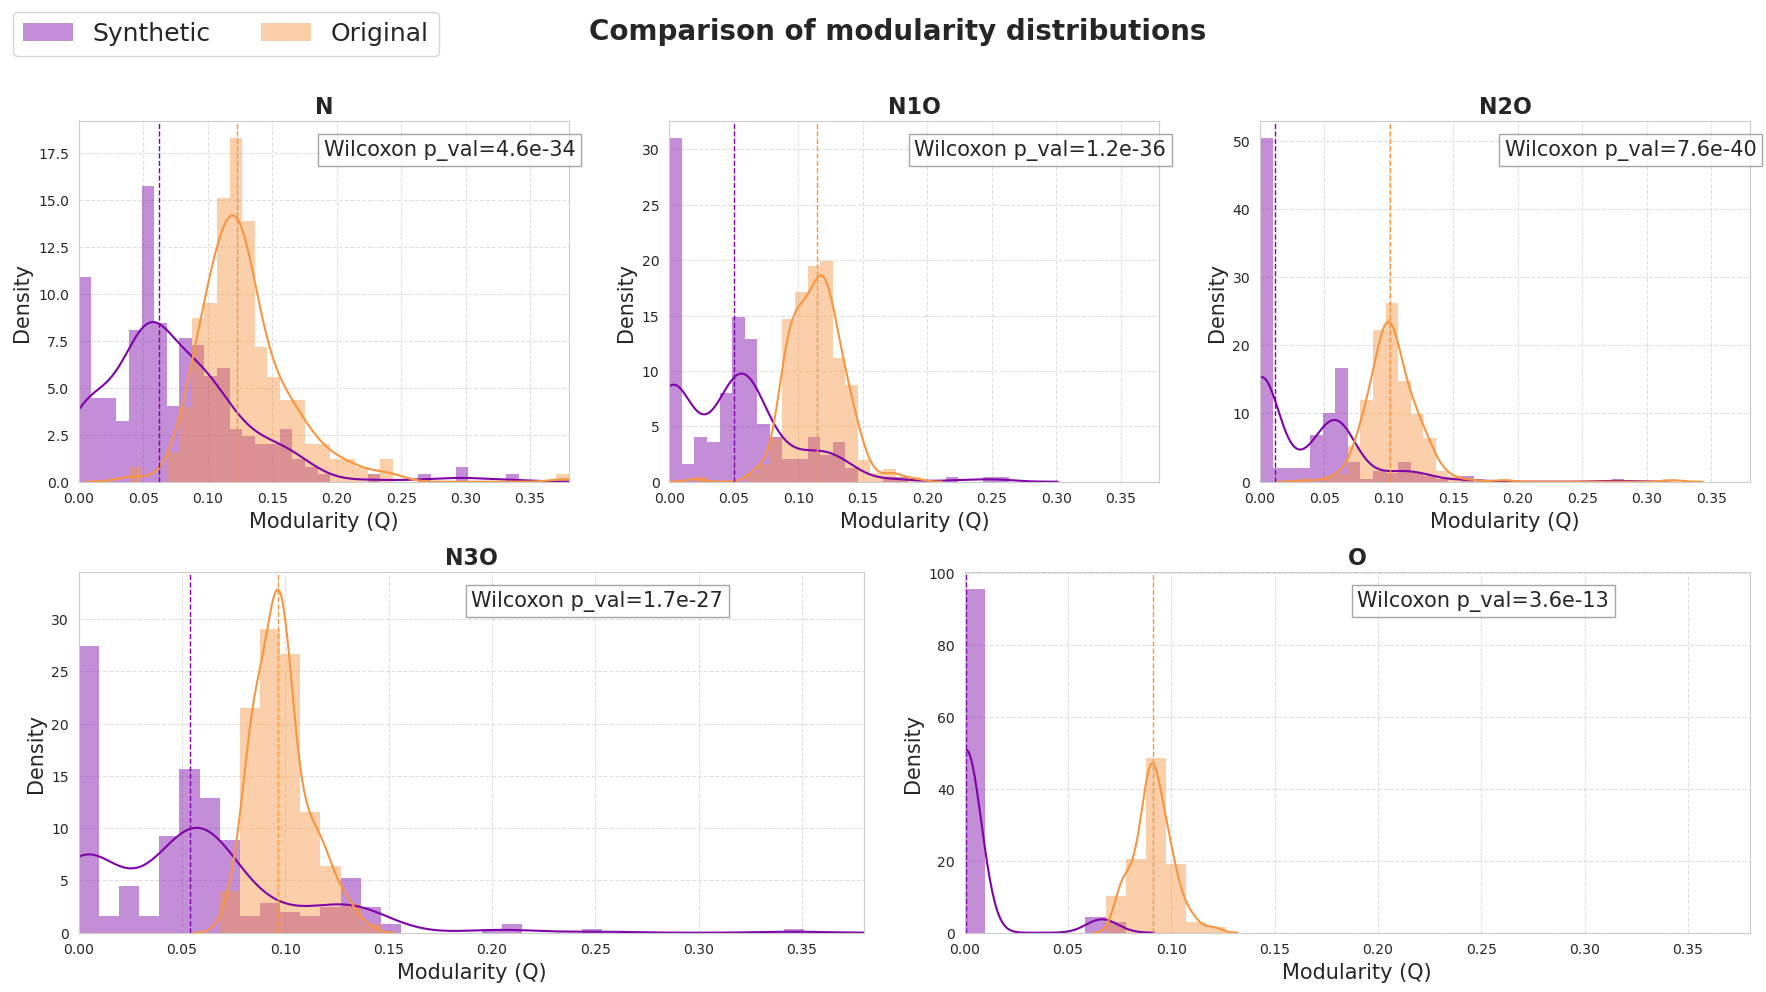

In [37]:
# Compare modularity between synthetic and original
sns.set_style("whitegrid")

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 6, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])
axes = [ax1, ax2, ax3, ax4, ax5]

fnames = list(file_names[:len(axes)])
keys = [f[:-4] for f in fnames]

# global bins for modularity (clip to [0,1] for plotting)
all_mod = []
for k in keys:
    all_mod.append(np.array(mody_synt[k], dtype=float))
    all_mod.append(np.array(mody[k], dtype=float))
all_mod = np.concatenate(all_mod)
low = max(0.0, np.floor(all_mod.min() * 100) / 100)   # round down a bit
high = min(1.0, np.ceil(all_mod.max() * 100) / 100)   # round up a bit
if low >= high:
    low, high = 0.0, 1.0
bins = np.linspace(low, high, 40)

syn_col = sns.color_palette("plasma", 3)[0]
orig_col = sns.color_palette("plasma", 3)[2]

for k, axi in zip(keys, axes):
    synt_vals = np.array(mody_synt[k], dtype=float)
    orig_vals  = np.array(mody[k], dtype=float)

    # hist + KDE
    axi.hist(synt_vals, bins=bins, density=True, alpha=0.45, color=syn_col, label='Synthetic', edgecolor='none')
    axi.hist(orig_vals,  bins=bins, density=True, alpha=0.45, color=orig_col, label='Original', edgecolor='none')
    sns.kdeplot(synt_vals, ax=axi, color=syn_col, lw=1.5)
    sns.kdeplot(orig_vals,  ax=axi, color=orig_col, lw=1.5)

    # medians
    m_syn = np.median(synt_vals)
    m_orig = np.median(orig_vals)
    axi.axvline(m_syn, color=syn_col, ls='--', lw=1)
    axi.axvline(m_orig, color=orig_col, ls='--', lw=1)

    # KS test
    ksres = wilcoxon(synt_vals[:min(len(synt_vals), len(orig_vals))], orig_vals[:min(len(synt_vals), len(orig_vals))])
    pval = ksres.pvalue
    stat = ksres.statistic
    axi.text(0.5, 0.95, f'Wilcoxon p_val={pval:.1e}', transform=axi.transAxes,
             verticalalignment='top', fontsize=15, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    axi.set_title(k.upper(), fontsize=16, fontweight='bold')
    axi.set_xlabel('Modularity (Q)', fontsize=15)
    axi.set_ylabel('Density', fontsize=15)
    axi.set_xlim(low, high)
    axi.grid(ls='--', alpha=0.6)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=18, frameon=True)

fig.suptitle('Comparison of modularity distributions', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## GO analysis

In [2]:
from goatools.anno.gaf_reader import GafReader
from goatools.utils import read_geneset
from goatools.obo_parser import GODag
from goatools.anno.idtogos_reader import IdToGosReader
from goatools.go_enrichment import GOEnrichmentStudy

In [88]:
working_dir = "data/GOdata"

In [ ]:
ogaf = GafReader(working_dir+"/goa_human.gaf")
godag = GODag(working_dir+"/go-basic.obo")

fin_pop   = working_dir+'/gobackground.list'  # Population genes
fin_obo   = working_dir+'/go-basic.obo'             # DAG containing HPO terms
fin_anno  = working_dir+'/ass.tab' # Annotation of genes-to-HPO terms

HMS:0:00:08.827387 638,732 annotations READ: data/GOdata/goa_human.gaf 
data/GOdata/go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms


In [95]:
def get_GO_enr(fin_study, fin_pop, fin_obo, fin_anno, methods=['bonferroni', 'fdr_bh'], pvalcalc='fisher_scipy_stats'):
    # Read study and population gene sets (one ID per line)
    study_ids = read_geneset(fin_study)
    population_ids = read_geneset(fin_pop)
    
    # Parse ontology DAG from OBO file
    godag = GODag(fin_obo)

    # Read annotations mapping IDs -> GO terms using the provided annotation file
    annoobj = IdToGosReader(fin_anno, godag=godag)
    id2gos = annoobj.get_id2gos()

    # Create GO enrichment study object with chosen multiple-testing methods and p-value calculator
    goeaobj = GOEnrichmentStudy(
        population_ids,
        id2gos,
        godag,
        methods=methods,
        pvalcalc=pvalcalc)
    
    # Run enrichment on the study set (non-terminating version that returns all results)
    results = goeaobj.run_study_nts(study_ids)

    # Collect relevant fields from results into a list of rows
    res_df = []
    # Sort results by BH FDR for stable ordering (smaller FDRs first)
    for ntd in sorted(results, key=lambda nt: nt.p_fdr_bh):
        res_df.append([
            ntd.NS,                       # GO namespace/type (BP/CC/MF)
            ntd.goterm.name,              # GO term name
            ntd.p_uncorrected,            # uncorrected p-value
            ntd.p_bonferroni,             # Bonferroni corrected p-value
            ntd.p_fdr_bh,                 # Benjamini-Hochberg FDR
            '{}/{}'.format(*ntd.ratio_in_study), # hits in study / study size
            '{}/{}'.format(*ntd.ratio_in_pop)    # hits in population / population size
        ])

    # Build pandas DataFrame and set consistent column names used elsewhere in the notebook
    res_df = pd.DataFrame(res_df)
    res_df.columns = ["GOtype", "GOterm", "uncorr pval", "Bonf", "FDR", "study ratio", "pop ratio"]
    return res_df


In [96]:
res_df=get_GO_enr(fin_study=working_dir+"/inters.txt", 
                  fin_pop=fin_pop, 
                  fin_obo=fin_obo, 
                  fin_anno=fin_anno
                  )

       81 READ: data/GOdata/inters.txt
   11,926 READ: data/GOdata/gobackground.list
data/GOdata/go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms
HMS:0:00:00.326367 289,242 annotations READ: data/GOdata/ass.tab 
19614 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 93% 11,071 of 11,926 population items found in association

Runing  Ontology Analysis: current study set of 81 IDs.
 85%     68 of     80 study items found in association
 99%     80 of     81 study items found in population(11926)
Calculating 20,406 uncorrected p-values using fisher_scipy_stats
  20,406 terms are associated with 11,071 of 11,926 population items
   2,559 terms are associated with     68 of     81 study items
  METHOD bonferroni:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): local bonferroni
      31 study items associated with significant GO IDs (enriched)
       0 study items associated wit

In [97]:
res_df[np.all([res_df['GOtype']=="BP", res_df['FDR']<0.05], axis=0)]

,GOtype,GOterm,uncorr pval,Bonf,FDR,study ratio,pop ratio
1,BP,regulation of transcription by RNA polymerase II,0.000001,0.026968,0.013484,29/80,1747/11926
2,BP,regulation of DNA-templated transcription,0.000003,0.069228,0.015225,34/80,2367/11926
3,BP,regulation of RNA metabolic process,0.000004,0.072367,0.015225,36/80,2591/11926
4,BP,regulation of RNA biosynthetic process,0.000004,0.076126,0.015225,34/80,2379/11926
6,BP,regulation of nucleobase-containing compound m...,0.000009,0.177816,0.025402,37/80,2822/11926
7,BP,positive regulation of RNA metabolic process,0.000018,0.373536,0.043272,24/80,1459/11926
8,BP,positive regulation of DNA-templated transcrip...,0.000020,0.417593,0.043272,23/80,1368/11926
9,BP,positive regulation of RNA biosynthetic process,0.000021,0.432720,0.043272,23/80,1371/11926


In [ ]:
surv_term=[]
for i in range(50):
    print(i)
    res_df=get_GO_enr(fin_study=working_dir+"/Synt/genes_"+str(i)+".list", 
                      fin_pop=fin_pop, 
                      fin_obo=fin_obo, 
                      fin_anno=fin_anno
                     )
    surv_term.append(res_df[res_df['GOtype']=="BP"])

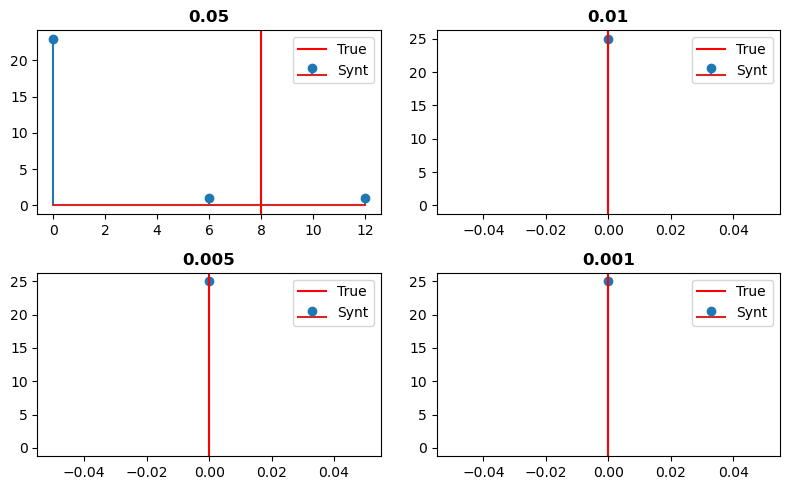

In [35]:
fdr_thr=[0.05,0.01,0.005,0.001]
_,ax=plt.subplots(2,2,figsize=(8,5))
ax=ax.flatten()
for i in range(4):
    ax[i].stem(*np.unique([len(r[r['FDR']<fdr_thr[i]]) for r in surv_term], return_counts=True), label="Synt")
    ax[i].axvline(len(res_df[np.all([res_df['FDR']<fdr_thr[i], res_df['GOtype']=="BP"], axis=0)]), color="red", label="True")
    ax[i].set_title(str(fdr_thr[i]), fontweight="bold")
    ax[i].legend()
#plt.ylim([0,45])
plt.tight_layout()